Here is a look at QE data from TS3 for both ITL and e2v sensors (with the final AR coating), calcluate an average QE curve for each sensor, after checking the data look OK for each segment, and compile for both types of sensors. Produce machine-readable curves. 

Questions, comments, problems to S.Ritz

In [1]:
# look at ITL fits files generated by TS3, analysis by Jim Chiang et al. We are looking at QE
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import astropy as ast
import astropy.stats
from astropy.io import fits
import scipy as sc
import scipy.signal
import textwrap
import pylab

# this magic command makes plots appear within the notebook
%matplotlib inline

# define figure size parameters to make figures larger than default
figwidth=10
figheight=10

In [2]:
class qe():
    def __init__(self,vend,number):
        self.v=vend
        self.n=number
        #print(self.v,self.n)
        # open the file
        vend=self.v
        number=self.n
        if vend=='ITL':
            filename=vend+'-3800C-'+number+'_QE.fits'
        elif vend=='E2V':
            filename=vend+'-CCD250-'+number+'_QE.fits'
        else:
           print('ERROR in vendor type')
        self.hdulist=fits.open(filename)
        self.filename=filename
        return;

    def info(self): 
        hdulist=self.hdulist
        hdulist.info()
        #print first extension's header
        print ("----------extension 1 header-------------") # amplifier-specific header info, mostly pixel placement information
        print ("  ")
        print (textwrap.fill(str(hdulist[1].header),80)) 
        return;

    def plotqe(self,ok):
        hdulist=self.hdulist
        qedata=hdulist[1].data
        vend=self.v
        number=self.n
        filename=self.filename
        # kludge for ITL-021, which has corrupted (nan) data
        if filename=='ITL-3800C-021_QE.fits':
            avg=(ok[2]*qedata['AMP02']+ok[3]*qedata['AMP03']+ok[4]*qedata['AMP04']+ok[5]*qedata['AMP05']+ok[6]*qedata['AMP06']+ok[7]*qedata['AMP07']+ok[8]*qedata['AMP08']+ok[9]*qedata['AMP09']+ok[10]*qedata['AMP10']+ok[11]*qedata['AMP11']+ok[12]*qedata['AMP12']+ok[13]*qedata['AMP13']+ok[14]*qedata['AMP14']+ok[15]*qedata['AMP15'])/sum(ok)
        else:
            avg=(ok[1]*qedata['AMP01']+ok[2]*qedata['AMP02']+ok[3]*qedata['AMP03']+ok[4]*qedata['AMP04']+ok[5]*qedata['AMP05']+ok[6]*qedata['AMP06']+ok[7]*qedata['AMP07']+ok[8]*qedata['AMP08']+ok[9]*qedata['AMP09']+ok[10]*qedata['AMP10']+ok[11]*qedata['AMP11']+ok[12]*qedata['AMP12']+ok[13]*qedata['AMP13']+ok[14]*qedata['AMP14']+ok[15]*qedata['AMP15']+ok[16]*qedata['AMP16'])/sum(ok)
        wavelength=qedata['WAVELENGTH']
        fig1=plt.figure(1,[figwidth,figheight])
        plt.subplot(211)
        plt.title('QE by AMP and Average')
        plt.ylabel('QE')
        #plt.xlabel('wavelength')
        fig1.suptitle(vend+'-'+number, fontsize=16)
        plt.scatter(wavelength, qedata['AMP01'], 15,'b','$1$')
        plt.scatter(wavelength, qedata['AMP02'], 15,'b','$2$')
        plt.scatter(wavelength, qedata['AMP03'], 15,'b','$3$')
        plt.scatter(wavelength, qedata['AMP04'], 15,'b','$4$')
        plt.scatter(wavelength, qedata['AMP05'], 15,'b','$5$')
        plt.scatter(wavelength, qedata['AMP06'], 15,'b','$6$')
        plt.scatter(wavelength, qedata['AMP07'], 15,'b','$7$')
        plt.scatter(wavelength, qedata['AMP08'], 15,'b','$8$')
        plt.scatter(wavelength, qedata['AMP09'], 15,'b','$9$')
        plt.scatter(wavelength, qedata['AMP10'], 15,'b','$A$')
        plt.scatter(wavelength, qedata['AMP11'], 15,'b','$B$')
        plt.scatter(wavelength, qedata['AMP12'], 15,'b','$C$')
        plt.scatter(wavelength, qedata['AMP13'], 15,'b','$D$')
        plt.scatter(wavelength, qedata['AMP14'], 15,'b','$E$')
        plt.scatter(wavelength, qedata['AMP15'], 15,'b','$F$')
        plt.scatter(wavelength, qedata['AMP16'], 15,'b','$G$')
        plt.scatter(wavelength, avg, 30,'r')
        ax=fig1.gca()
        ax.grid(True)
        ax.set_xticks(np.arange(300, 1150, 50.))
        ax.set_yticks(np.arange(0, 110., 5.))
        if sum(ok)!=16:
            plt.annotate('NOTE: some segments not included in average', xy=(0.15, 0.25), xycoords='axes fraction')
        plt.subplot(212)
        plt.title('u/z')
        plt.xlabel('AMP')
        bands=hdulist[2].data
#        print(bands[0][1:17])
        plt.ylim([.5,1.])
        rav=0.
        rav2=0.
        ratmax=-100.
        ratmin=100.
        for i in range(1,17):
            if ok[i]!=0:
                rat=bands[0][i]/bands[2][i]
                if rat>ratmax:
                    ratmax=rat
                if rat<ratmin:
                    ratmin=rat
                rav=rav+rat
                rav2=rav2+rat**2
                plt.scatter(i, rat, 20,'b')
                plt.errorbar(i, rat, xerr=.5,color='b')
        rav=rav/sum(ok)
        peaks=(ratmax-ratmin)/rav
        rms=np.sqrt(rav2/sum(ok)-rav**2)
        plt.hlines(rav,0.5,16.5,linestyles='dashed',color='b')
        plt.text(13.,.93,'rms = '+str(round(rms,3)))
        plt.text(13.,.9,'peak spread = '+str(round(peaks*100,1))+'%')
        label=vend+'-'+number
        fig1.savefig(vend+'test-'+number+'.pdf')
        ok=[0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1] # reset to default for next one
        zz=[wavelength,avg,label]
        return zz,ok;

In [3]:
# inititialization
ok=[0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1] # AMPs to include in average -- throw away index 0 to match
sitl=[[]]
se2v=[[]]
cmap = { 0:'r',1:'g',2:'b',3:'c',4:'m',5:'y',6:'k',7:'gray',8:'orange',9:'darkslateblue',10:'coral',11:'darkblue',12:'darkred' }

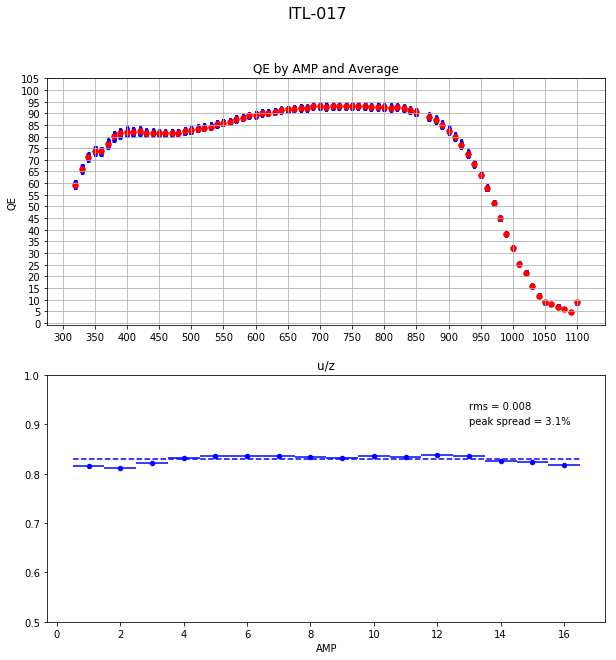

In [4]:
f=qe('ITL','017')
qecurve,ok=f.plotqe(ok)
#f.info()
sitl.append(qecurve)

OMITTING SENSOR FROM AVERAGE. Data problems.


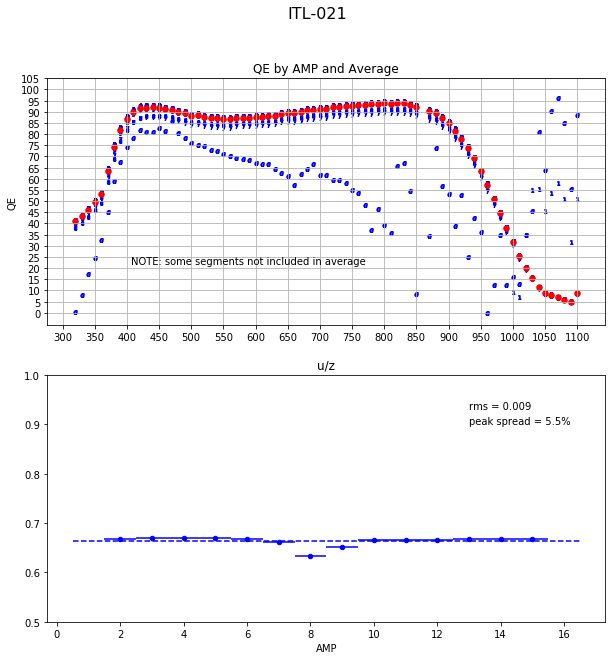

In [5]:
# skip 21, data look a mess
ok=[0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0] #remove amps 1 and 16 from the average, then put them back for the next sensor
f=qe('ITL','021')
qecurve,ok=f.plotqe(ok)
#sitl.append(qecurve)
print('OMITTING SENSOR FROM AVERAGE. Data problems.')


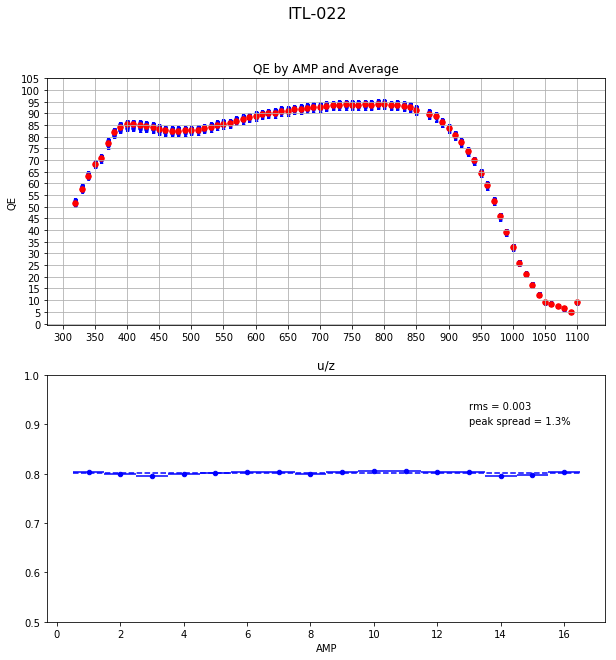

In [6]:
f=qe('ITL','022')
qecurve,ok=f.plotqe(ok)
sitl.append(qecurve)

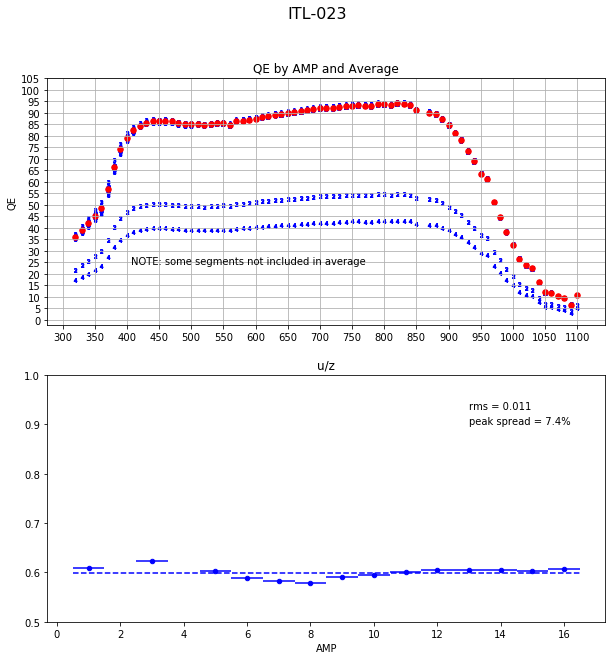

In [7]:
ok=[0,1,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1] # AMPs to include in average -- throw away index 0 to match
f=qe('ITL','023')
qecurve,ok=f.plotqe(ok)
sitl.append(qecurve)

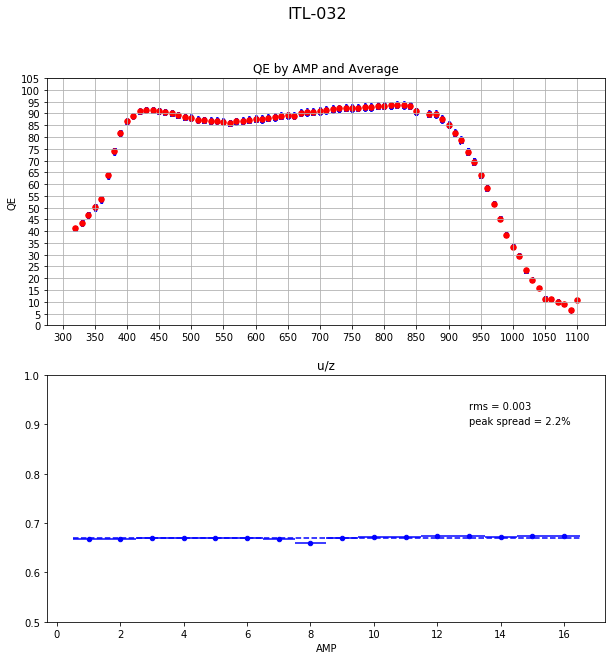

In [8]:
f=qe('ITL','032')
qecurve,ok=f.plotqe(ok)
sitl.append(qecurve)

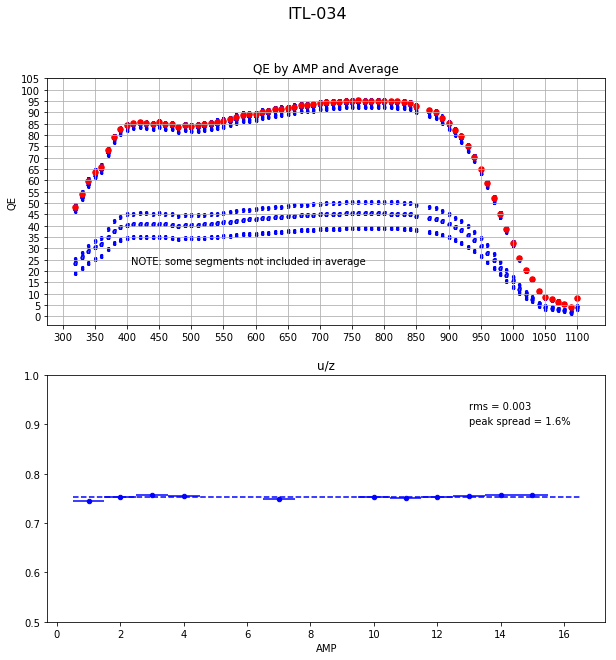

In [9]:
ok=[0,1,1,1,1,0,0,1,0,0,1,1,1,1,1,1,0] # AMPs to include in average -- throw away index 0 to match
f=qe('ITL','034')
qecurve,ok=f.plotqe(ok)
sitl.append(qecurve)

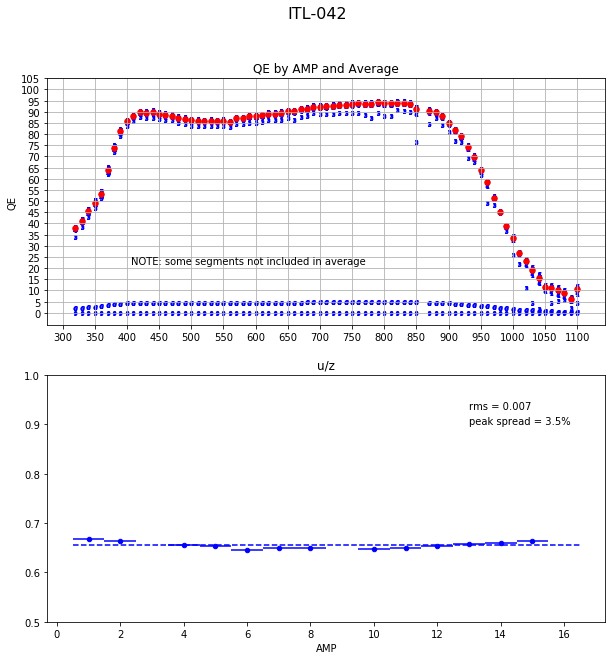

In [10]:
ok=[0,1,1,0,1,1,1,1,1,0,1,1,1,1,1,1,0] # AMPs to include in average -- throw away index 0 to match
f=qe('ITL','042')
qecurve,ok=f.plotqe(ok)
sitl.append(qecurve)

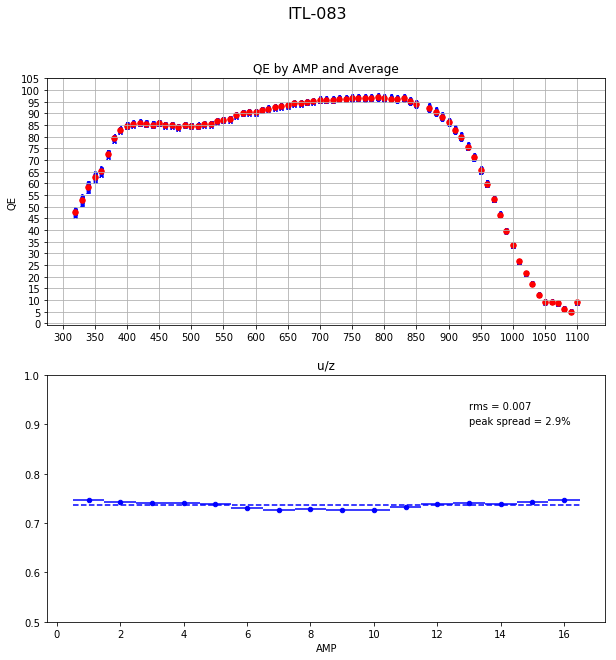

In [11]:
f=qe('ITL','083')
qecurve,ok=f.plotqe(ok)
sitl.append(qecurve)

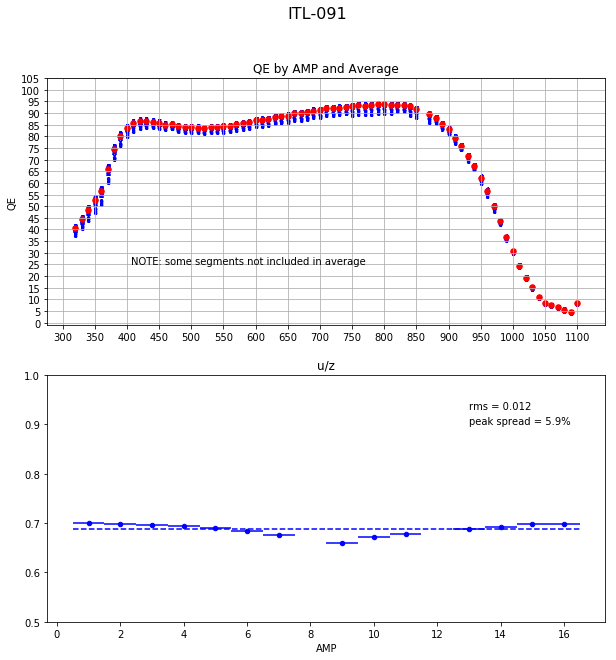

In [12]:
ok=[0,1,1,1,1,1,1,1,0,1,1,1,0,1,1,1,1] # AMPs to include in average -- throw away index 0 to match
f=qe('ITL','091')
qecurve,ok=f.plotqe(ok)
sitl.append(qecurve)

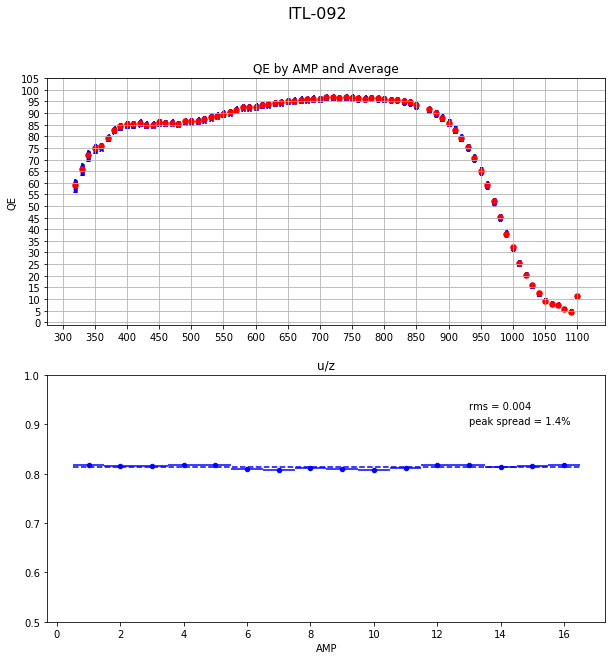

In [13]:
f=qe('ITL','092')
qecurve,ok=f.plotqe(ok)
sitl.append(qecurve)

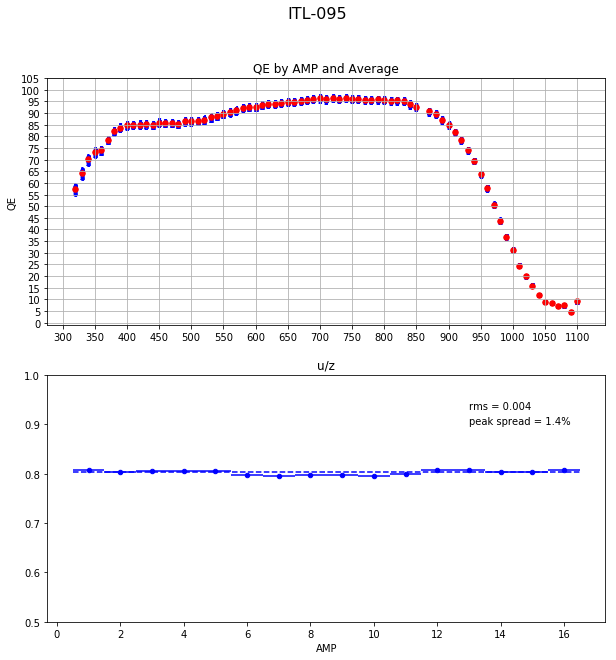

In [14]:
f=qe('ITL','095')
qecurve,ok=f.plotqe(ok)
sitl.append(qecurve)

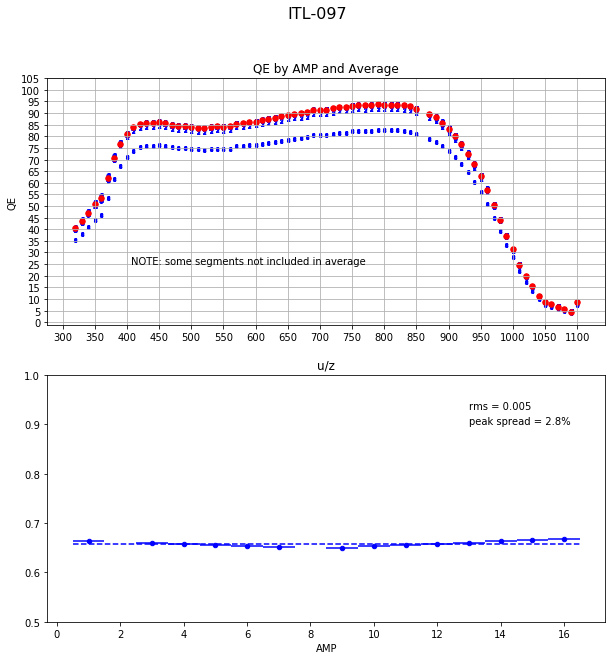

In [15]:
ok=[0,1,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1] # AMPs to include in average -- throw away index 0 to match
f=qe('ITL','097')
qecurve,ok=f.plotqe(ok)
sitl.append(qecurve)

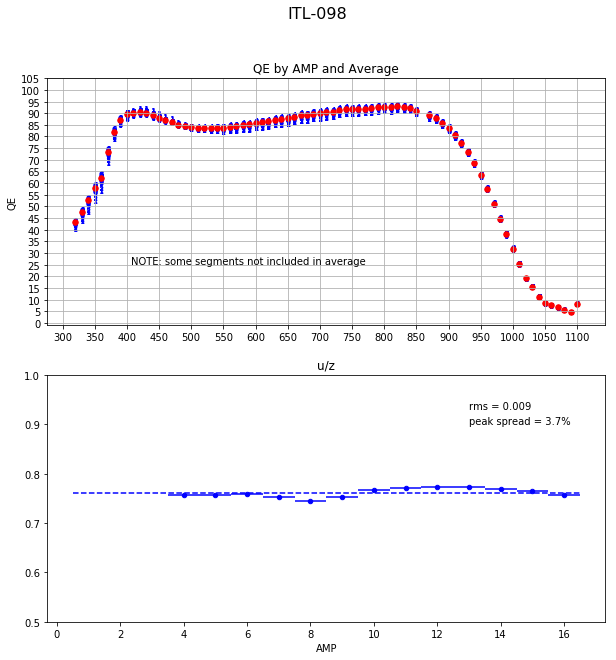

In [16]:
ok=[0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1] # AMPs to include in average -- throw away index 0 to match
f=qe('ITL','098')
qecurve,ok=f.plotqe(ok)
sitl.append(qecurve)

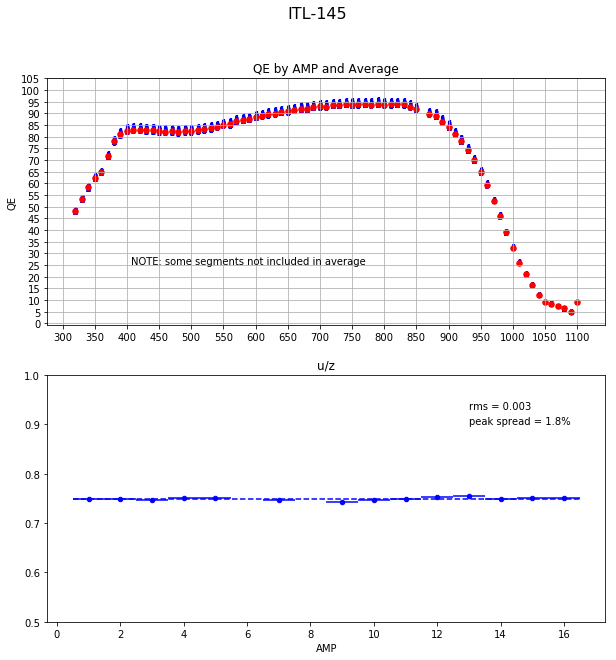

In [17]:
ok=[0,1,1,1,1,1,0,1,0,1,1,1,1,1,1,1,1] # AMPs to include in average -- throw away index 0 to match
f=qe('ITL','145')
qecurve,ok=f.plotqe(ok)
sitl.append(qecurve)

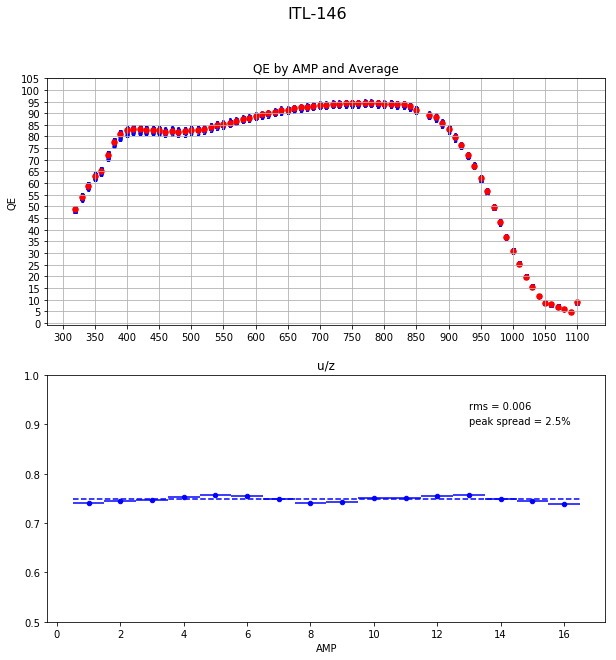

In [18]:
f=qe('ITL','146')
qecurve,ok=f.plotqe(ok)
sitl.append(qecurve)


And now for e2V

In [19]:
#skip 114 looks like old coating
#ok=[0,0,0,0,1,1,1,0,1,1,1,1,1,1,1,1,1] 

In [20]:
#skip 107 -- looks like old coating

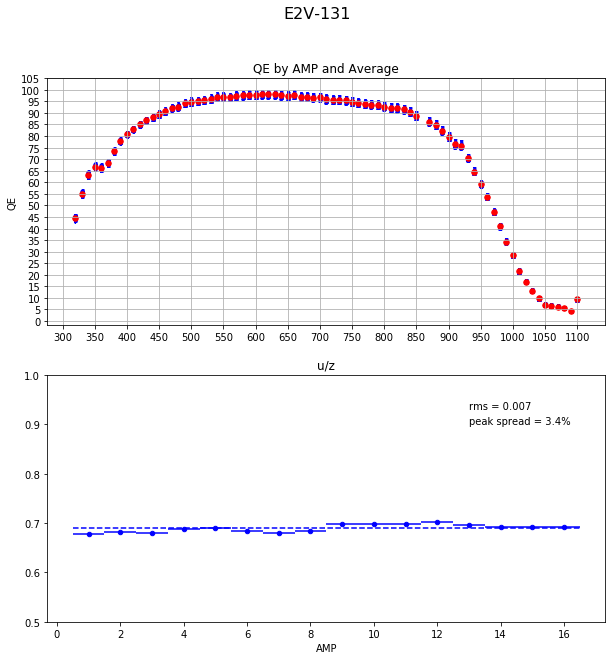

In [21]:
f=qe('E2V','131')
qecurve,ok=f.plotqe(ok)
se2v.append(qecurve)

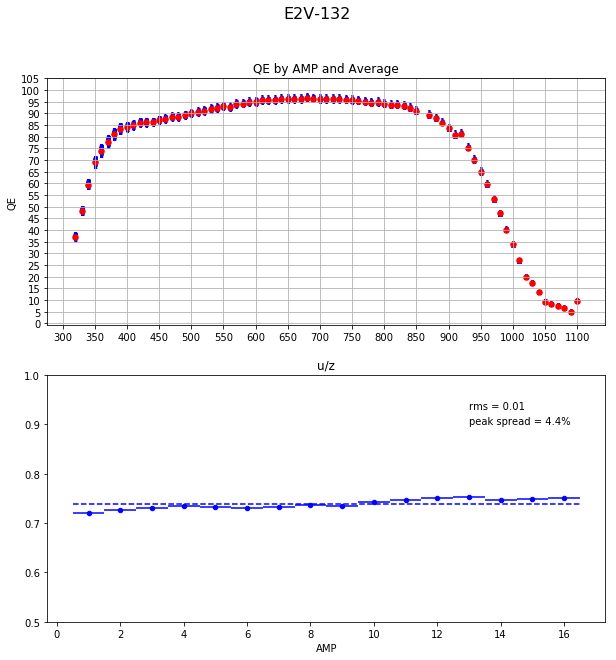

In [22]:
f=qe('E2V','132')
qecurve,ok=f.plotqe(ok)
se2v.append(qecurve)

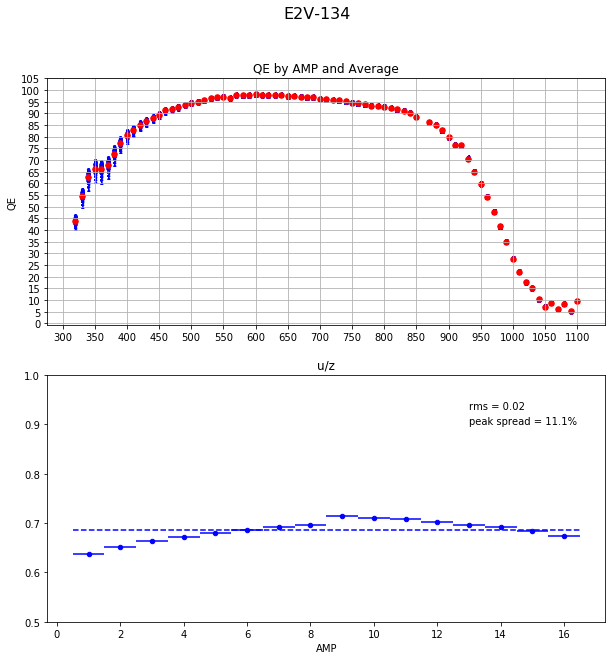

In [23]:
f=qe('E2V','134')
qecurve,ok=f.plotqe(ok)
se2v.append(qecurve)

Notice the spread by segment at short wavelength, and the trend by segment, suggesting AR coating nonuniformity. Here's the image from the EO test report. 
<img src="pic-e2v134-350nm.png" alt="Drawing" style="width: 400px;"/>
Note that the PRNU requirement is 5% rms (not binned by amplifier).

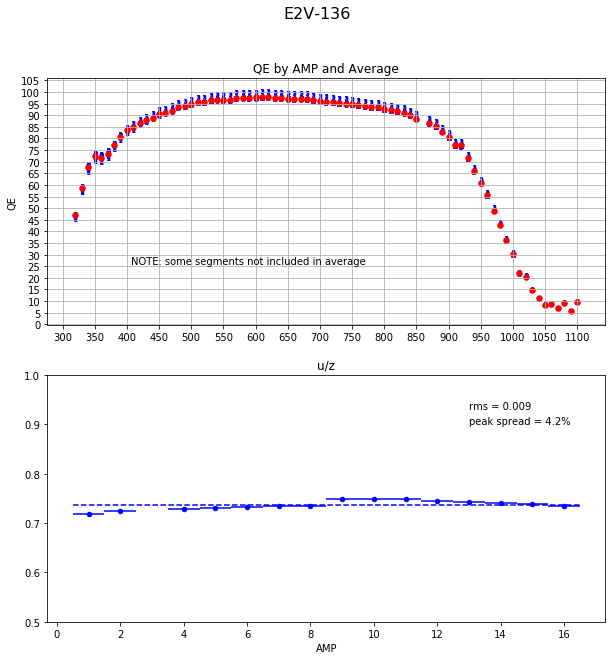

In [24]:
ok=[0,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1] 
f=qe('E2V','136')
qecurve,ok=f.plotqe(ok)
se2v.append(qecurve)

OMITTING FROM AVERAGE. Normalization looks wrong.


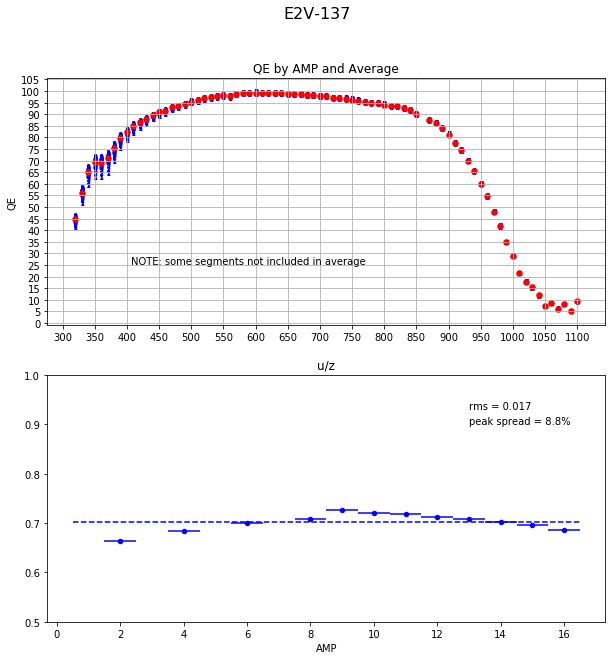

In [25]:
#skip 137 overall normalization looks a little off (too high)
ok=[0,0,1,0,1,0,1,0,1,1,1,1,1,1,1,1,1] #remove amps 1, 3, 5, 7 from the average, then put them back for the next sensor
f=qe('E2V','137')
qecurve,ok=f.plotqe(ok)
#se2v.append(qecurve)
print('OMITTING FROM AVERAGE. Normalization looks wrong.')

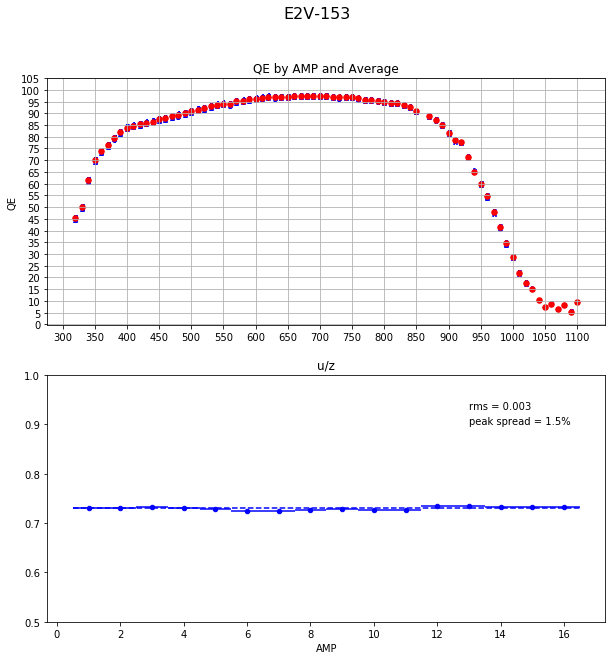

In [26]:
f=qe('E2V','153')
qecurve,ok=f.plotqe(ok)
se2v.append(qecurve)

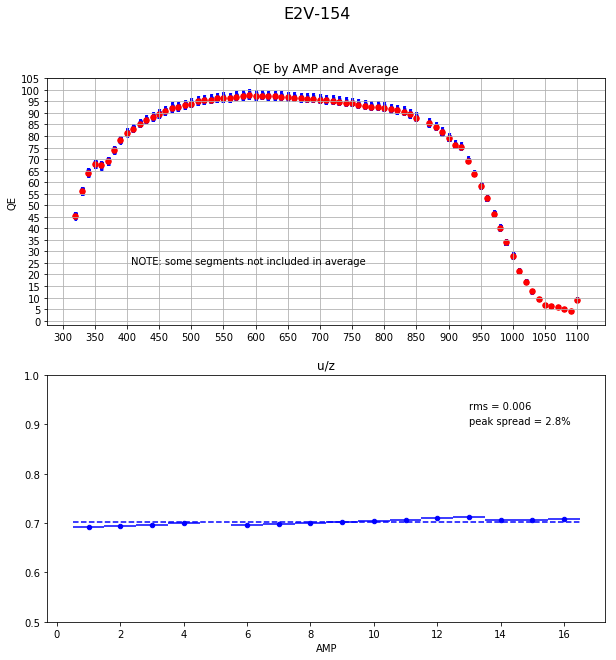

In [27]:
ok=[0,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1] # AMPs to include in average -- throw away index 0 to match
f=qe('E2V','154')
qecurve,ok=f.plotqe(ok)
se2v.append(qecurve)

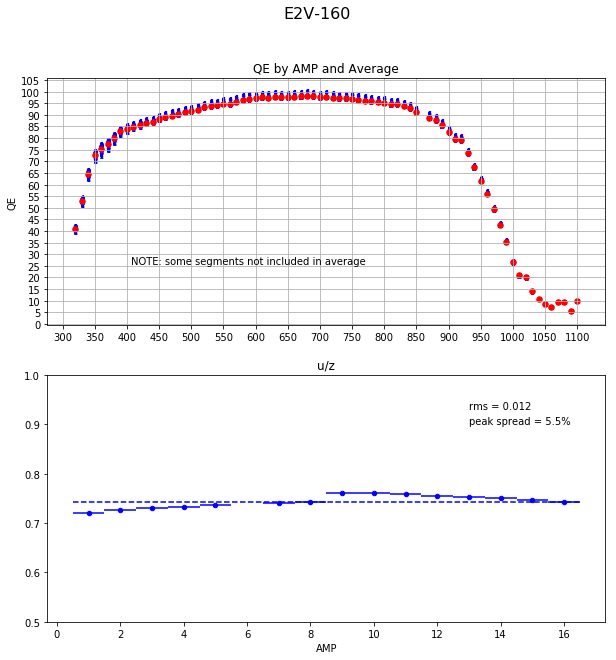

In [28]:
ok=[0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1] 
f=qe('E2V','160')
qecurve,ok=f.plotqe(ok)
se2v.append(qecurve)

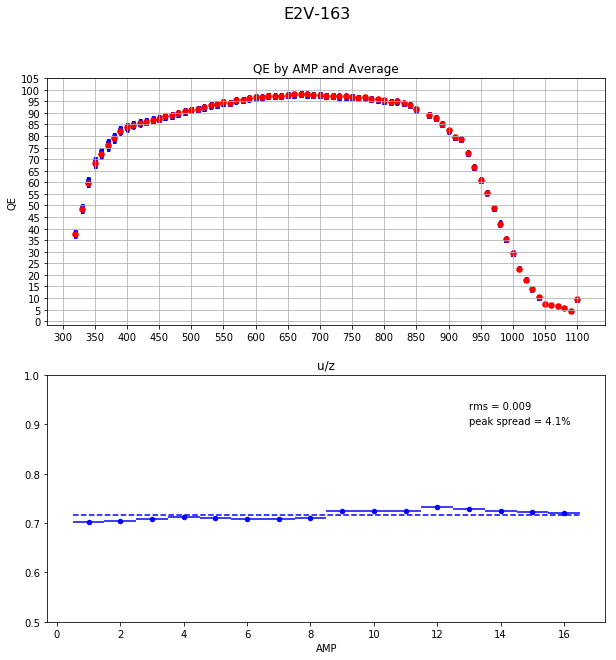

In [29]:
f=qe('E2V','163')
qecurve,ok=f.plotqe(ok)
se2v.append(qecurve)

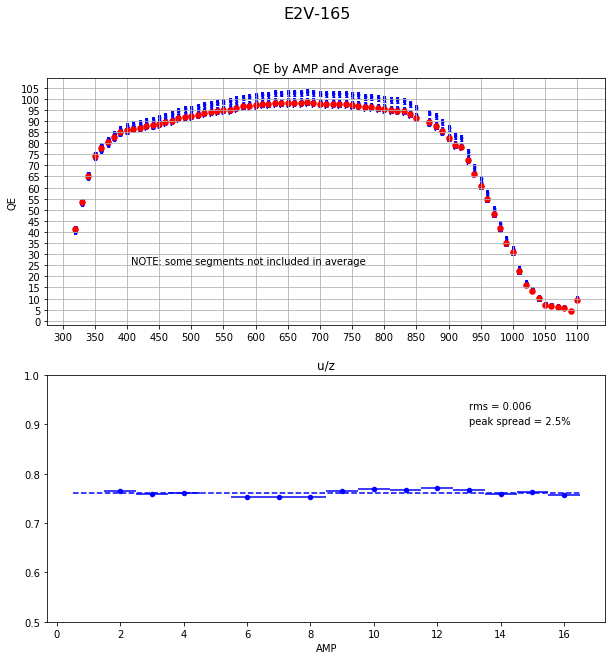

In [30]:
ok=[0,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1] 
f=qe('E2V','165')
qecurve,ok=f.plotqe(ok)
se2v.append(qecurve)

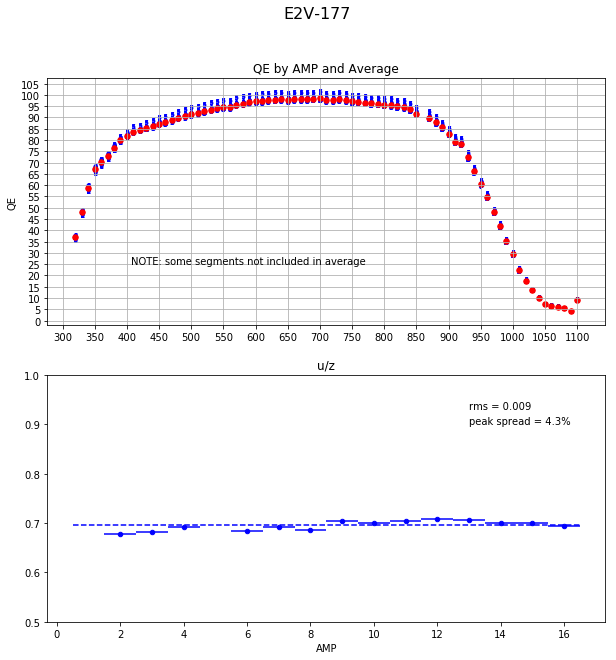

In [31]:
ok=[0,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1] # AMPs to include in average -- throw away index 0 to match
f=qe('E2V','177')
qecurve,ok=f.plotqe(ok)
se2v.append(qecurve)

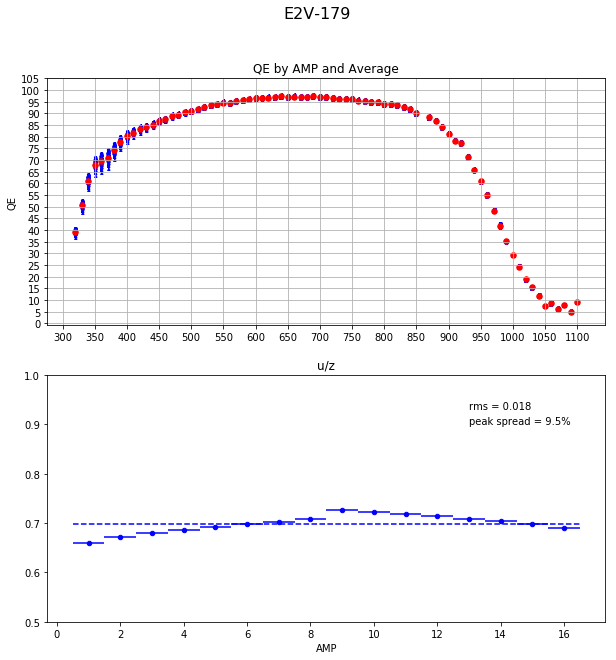

In [32]:
f=qe('E2V','179')
qecurve,ok=f.plotqe(ok)
se2v.append(qecurve)

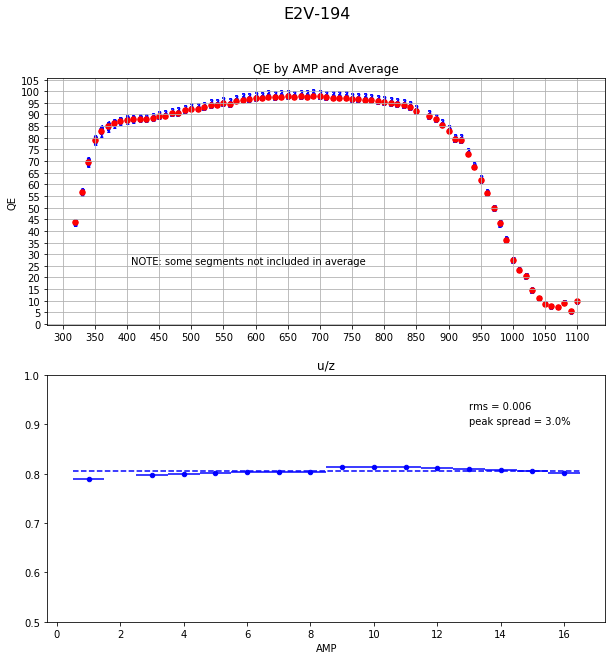

In [33]:
ok=[0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1] 
f=qe('E2V','194')
qecurve,ok=f.plotqe(ok)
se2v.append(qecurve)

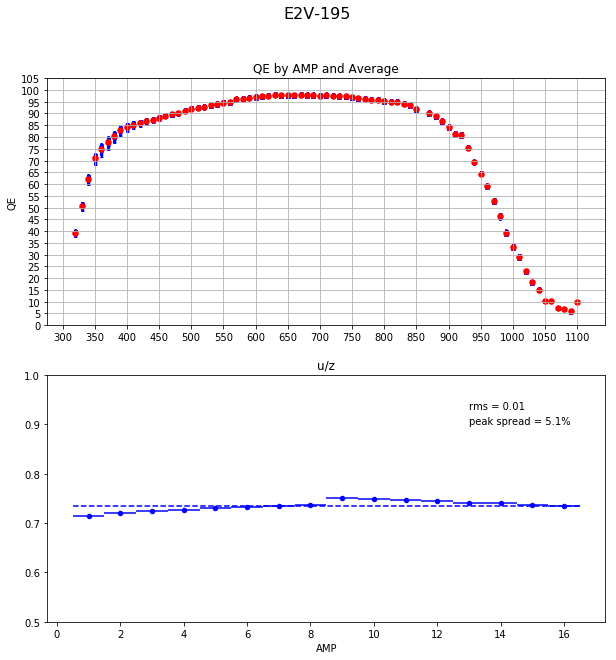

In [34]:
f=qe('E2V','195')
qecurve,ok=f.plotqe(ok)
se2v.append(qecurve)

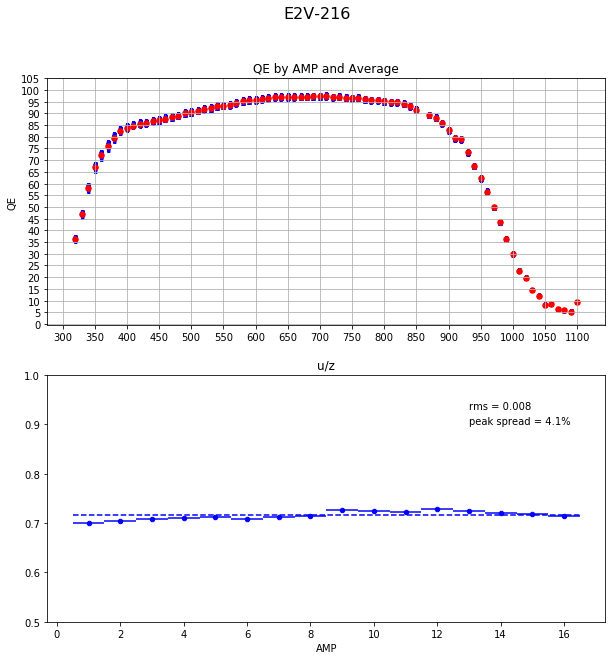

In [35]:
f=qe('E2V','216')
qecurve,ok=f.plotqe(ok)
se2v.append(qecurve)

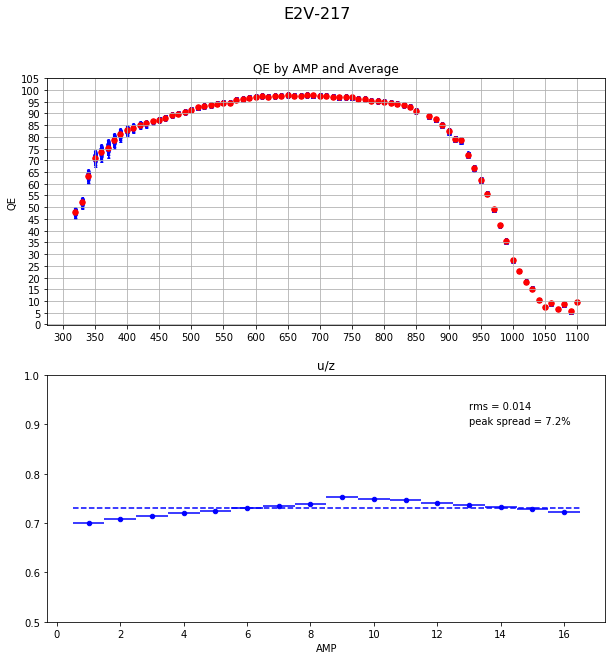

In [36]:
f=qe('E2V','217')
qecurve,ok=f.plotqe(ok)
se2v.append(qecurve)

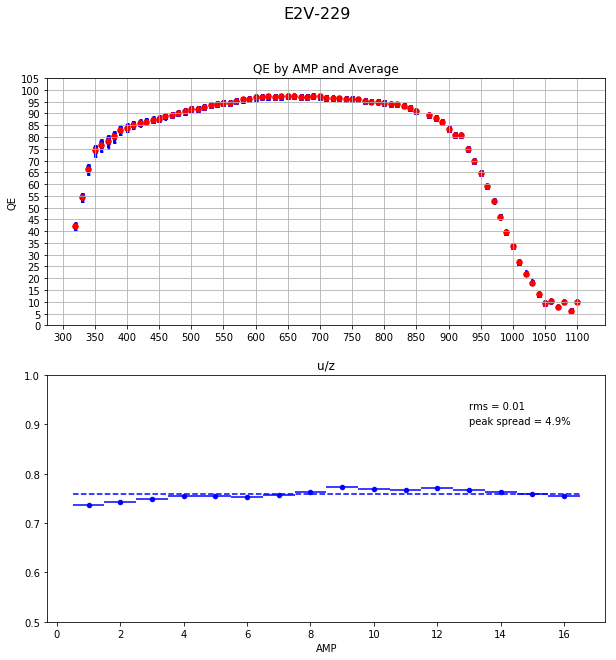

In [37]:
f=qe('E2V','229')
qecurve,ok=f.plotqe(ok)
se2v.append(qecurve)

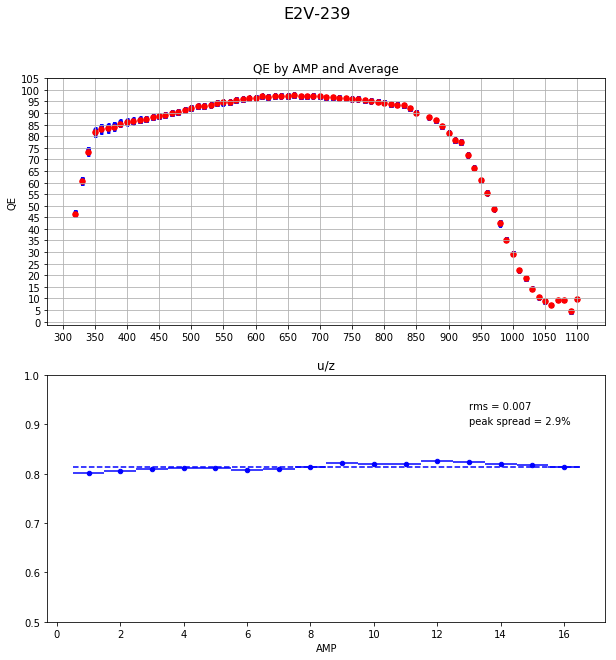

In [38]:
f=qe('E2V','239')
qecurve,ok=f.plotqe(ok)
se2v.append(qecurve)

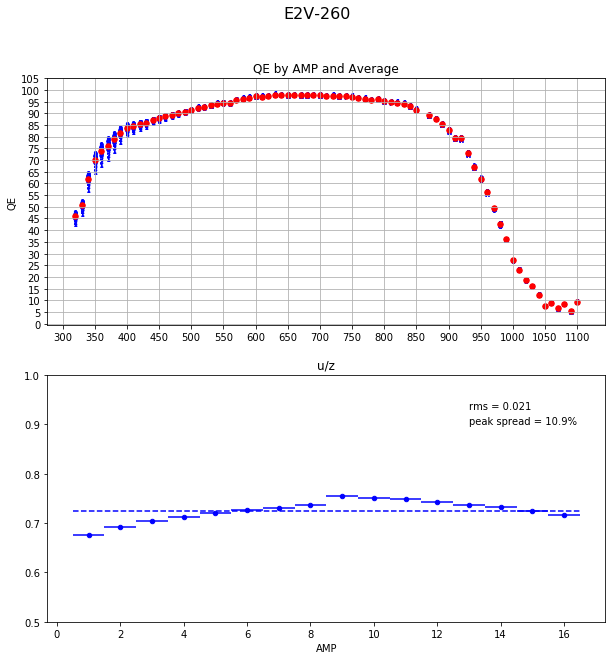

In [39]:
f=qe('E2V','260')
qecurve,ok=f.plotqe(ok)
se2v.append(qecurve)

Significant variation across the sensor, likely the AR coating. Here are the images from the EO test report using vendor data:
<img src="pic-e2v260-350nm.png" alt="Drawing" style="width: 400px;"/>
Note that the PRNU requirement is 5% rms (not binned by amplifier).

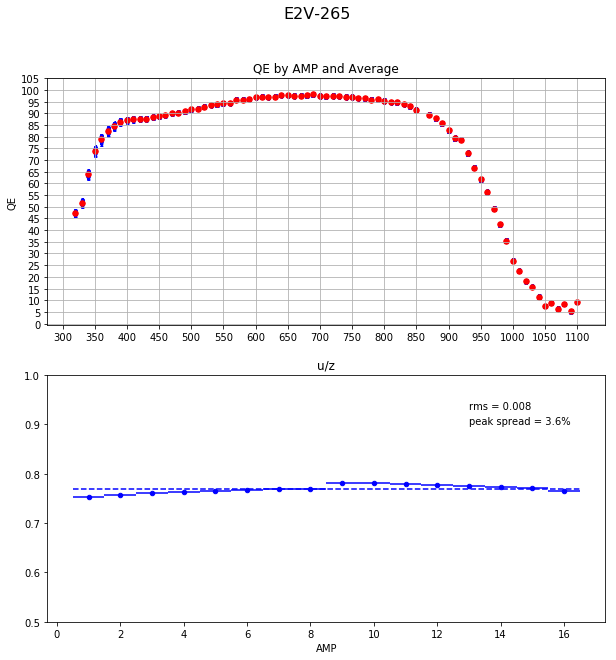

In [40]:
f=qe('E2V','265')
qecurve,ok=f.plotqe(ok)
se2v.append(qecurve)

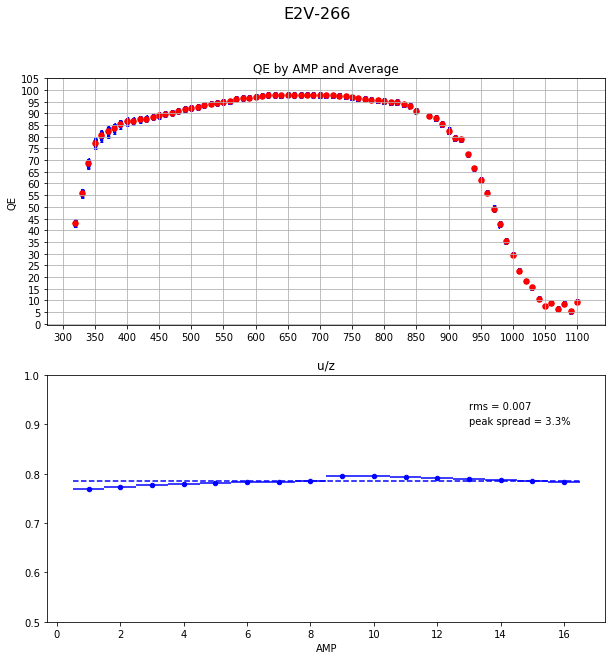

In [41]:
f=qe('E2V','266')
qecurve,ok=f.plotqe(ok)
se2v.append(qecurve)

OMITTING SENSOR FROM AVERAGE. Normalization looks wrong.


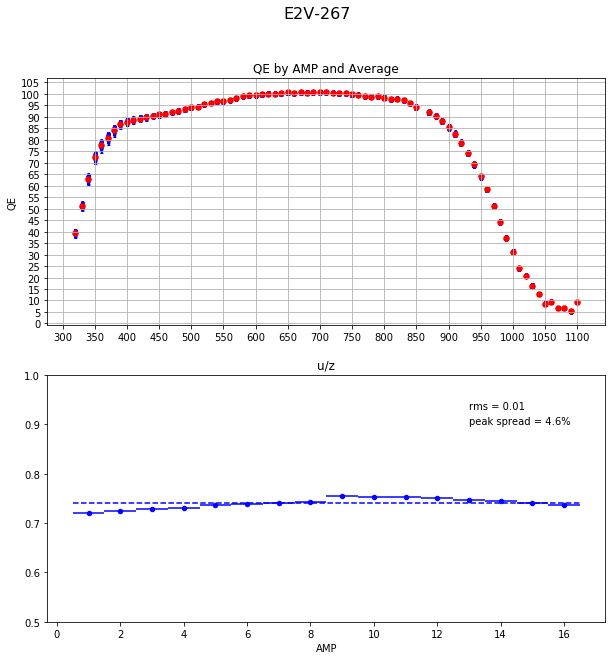

In [42]:
# skip 267, overall normalization looks wrong (>100%)
f=qe('E2V','267')
qecurve,ok=f.plotqe(ok)
#se2v.append(qecurve)
print('OMITTING SENSOR FROM AVERAGE. Normalization looks wrong.')

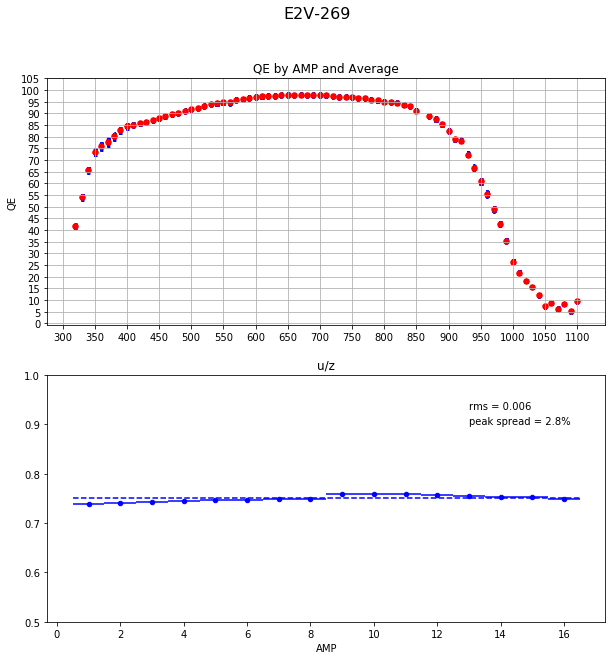

In [43]:
f=qe('E2V','269')
qecurve,ok=f.plotqe(ok)
se2v.append(qecurve)

OMITTING FROM AVERAGE. Normalization looks wrong.


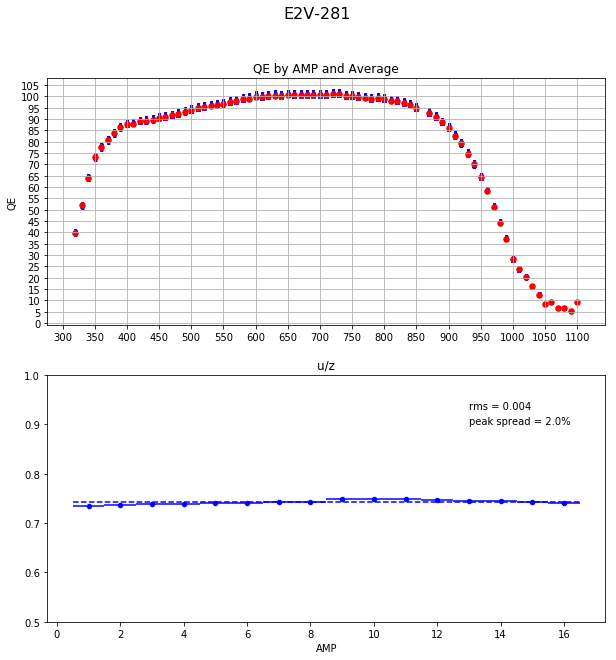

In [44]:
# looks like normalization problem for all of 281 -- above 100% on many amps
f=qe('E2V','281')
qecurve,ok=f.plotqe(ok)
#se2v.append(qecurve)
print('OMITTING FROM AVERAGE. Normalization looks wrong.')

In [45]:
#ok=[0,1,0,1,1,1,1,1,1,1,0,1,0,0,1,1,1] # AMPs to include in average -- throw away index 0 to match
#qecurve=plotqe('ITL','089',ok)
#ok=[0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1] # AMPs to include in average -- throw away index 0 to match
#itlsuper=itlsuper+qecurve[1]
#itlsensor.append(qecurve[1])
#itllabel.append(qecurve[2])

14 ITL sensors   and   21 e2V sensors


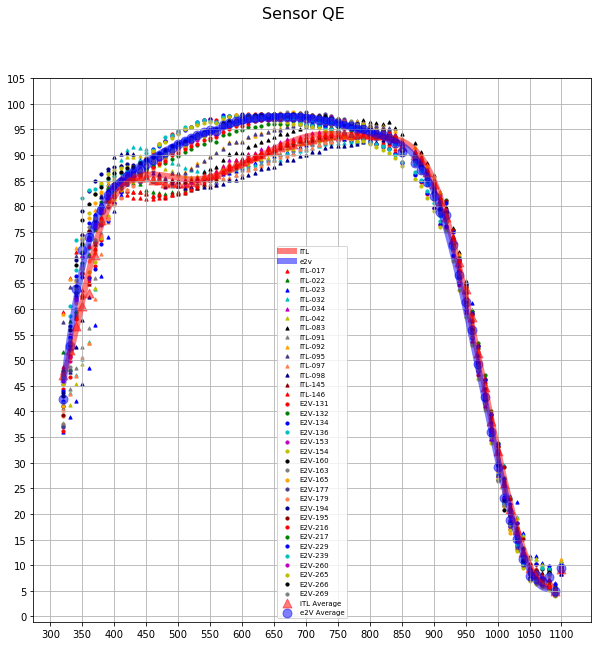

In [46]:
wavelength=qecurve[0]
superavgi=[0]*78
superavge=[0]*78
superavgi2=[0]*78
superavge2=[0]*78
print(len(sitl)-1,'ITL sensors   and  ',len(se2v)-1,'e2V sensors')
for i in range(1,len(sitl)):
    superavgi=superavgi+sitl[i][1]
    superavgi2=superavgi2+sitl[i][1]**2
superavgi=superavgi/(len(sitl)-1)
superavgi2=superavgi2/(len(sitl)-1)
for i in range(1,len(se2v)):
    superavge=superavge+se2v[i][1]
    superavge2=superavge2+se2v[i][1]**2
superavge=superavge/(len(se2v)-1)
superavge2=superavge2/(len(se2v)-1)
rmsi=np.sqrt(superavgi2-superavgi**2)
rmse=np.sqrt(superavge2-superavge**2)
#print(rmsi)
# now let's interpolate
from scipy import interpolate
#itl=interpolate.interp1d(wavelength,superavg,kind='cubic')
#e2v=interpolate.interp1d(wavelength,superavge,kind='cubic')
itl=interpolate.UnivariateSpline(wavelength,superavgi)
e2v=interpolate.UnivariateSpline(wavelength,superavge)
#ritl=interpolate.UnivariateSpline(wavelength,rmsi)
#re2v=interpolate.UnivariateSpline(wavelength,rmse)
lambda1=np.arange(321,1075,1)
itlcurve=itl(lambda1)
e2vcurve=e2v(lambda1)
#ritlcurve=ritl(lambda1)
#re2vcurve=re2v(lambda1)
fig1=plt.figure(1,[figwidth,figheight])
#fig1.ylabel('QE')
fig1.suptitle('Sensor QE', fontsize=16)
plt.plot(lambda1, itlcurve,'r',linewidth=6,label='ITL',alpha=0.5)
plt.plot(lambda1, e2vcurve,'b', linewidth=6, label='e2v',alpha=0.5)
for i in range(1,len(sitl)):
    plt.scatter(wavelength, sitl[i][1], 10,cmap[(i-1)%(len(cmap))],'^',label=sitl[i][2])
for i in range(1,len(se2v)):
    plt.scatter(wavelength, se2v[i][1], 10,cmap[(i-1)%(len(cmap))],'o',label=se2v[i][2])
plt.scatter(wavelength, superavgi, 80,'r','^',label='ITL Average', alpha=0.5)
plt.scatter(wavelength, superavge, 80,'b', label='e2V Average', alpha=0.5)
#plt.scatter(wavelength, avg179e, 50,'y', label='e2V-179')
#fig1.legend(loc=2,prop={'size':6})
pylab.legend(loc='lower center',prop={'size':7})
ax=fig1.gca()
ax.grid(True)
ax.set_xticks(np.arange(300, 1150, 50.))
ax.set_yticks(np.arange(0, 110., 5.))
fig1.savefig('SensorQE.pdf')

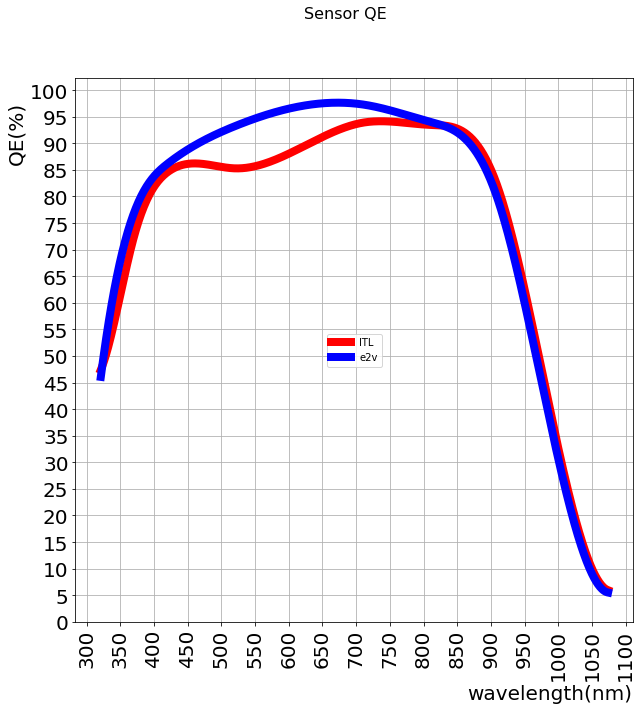

In [72]:
fig1=plt.figure(1,[figwidth,figheight])
fig1.suptitle('Sensor QE', fontsize=16)
plt.plot(lambda1, itlcurve,'r',linewidth=8,label='ITL')
plt.plot(lambda1, e2vcurve,'b', linewidth=8, label='e2v')
#plt.plot(lambda1, ritlcurve,'r',linewidth=2,label='RMS ITL')
#plt.plot(lambda1, re2vcurve,'b', linewidth=2, label='RMS e2v')
pylab.legend(loc='center')
ax=fig1.gca()
ax.set_xticks(np.arange(300, 1150, 50.))
ax.set_yticks(np.arange(0, 105., 5.))
ax.grid(True)
plt.xticks(fontsize=20, rotation=90)
ax.set_xlabel('wavelength(nm)',fontsize=20,position=(.85,.9))
plt.yticks(fontsize=20)
ax.set_ylabel('QE(%)',fontsize=20, position=(1.,.9))
fig1.savefig('qecurves.pdf')
# and output
file1 = open("itl2017july24.txt","w")
for i in range(len(lambda1)):
    print (round(lambda1[i],1),round(itlcurve[i],1), file=file1)
file1.close()
file1 = open("e2v2017july24.txt","w")
for i in range(len(lambda1)):
    print (round(lambda1[i],1),round(e2vcurve[i],1), file=file1)
file1.close()

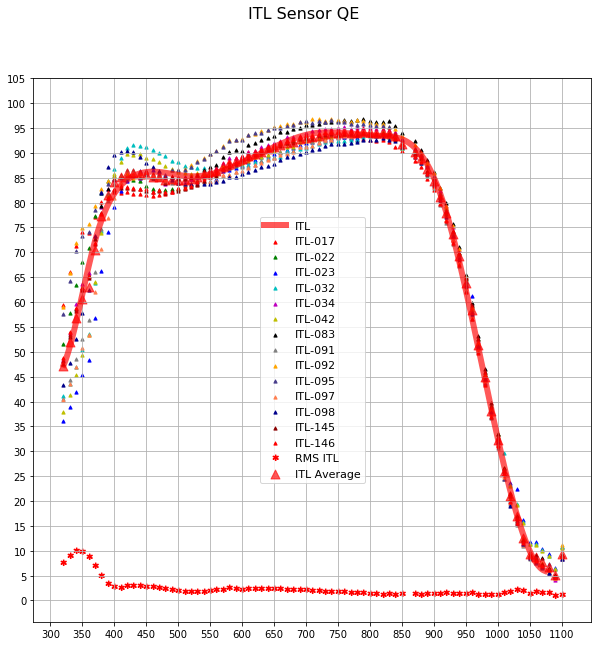

In [48]:
# now ITL only
fig1=plt.figure(1,[figwidth,figheight])
#fig1.ylabel('QE')
fig1.suptitle('ITL Sensor QE', fontsize=16)
plt.plot(lambda1, itlcurve,'r',linewidth=6,label='ITL',alpha=0.65)
for i in range(1,len(sitl)):
    plt.scatter(wavelength, sitl[i][1], 10,cmap[(i-1)%(len(cmap))],'^',label=sitl[i][2])
plt.scatter(wavelength, rmsi, 80,'r','$*$',label='RMS ITL')
plt.scatter(wavelength, superavgi, 80,'r','^',label='ITL Average', alpha=0.65)
#plt.errorbar(wavelength, superavgi, rmsi, fmt='', color='r')
pylab.legend(loc='center',prop={'size':11})
ax=fig1.gca()
ax.grid(True)
ax.set_xticks(np.arange(300, 1150, 50.))
ax.set_yticks(np.arange(0, 110., 5.))
fig1.savefig('SensorQE-ITL.pdf')

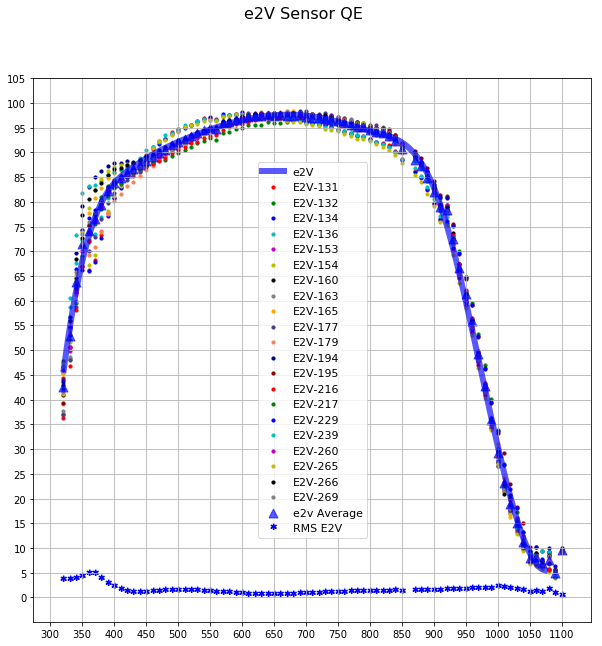

In [49]:
# now E2V only
fig1=plt.figure(1,[figwidth,figheight])
#fig1.ylabel('QE')
fig1.suptitle('e2V Sensor QE', fontsize=16)
plt.plot(lambda1, e2vcurve,'b',linewidth=6,label='e2V',alpha=0.65)
for i in range(1,len(se2v)):
    plt.scatter(wavelength, se2v[i][1], 10,cmap[(i-1)%(len(cmap))],'o',label=se2v[i][2])
plt.scatter(wavelength, superavge, 80,'b','^',label='e2v Average', alpha=0.65)
plt.scatter(wavelength, rmse, 80,'b','$*$',label='RMS E2V')
#plt.errorbar(wavelength, superavge, rmse, fmt='', color='b')
pylab.legend(loc='center',prop={'size':11})
ax=fig1.gca()
ax.grid(True)
ax.set_xticks(np.arange(300, 1150, 50.))
ax.set_yticks(np.arange(0, 110., 5.))
fig1.savefig('SensorQE-e2v.pdf')